<a href="https://colab.research.google.com/github/JapiKredi/EDA_extensive_library/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Credit-Card Fraud Detection**



1. Introduction
2. Preliminaries - load packages
3. Import dataset
4. Exploratory data analysis
5. Predictive modeling
6. Results and conclusion
7. References

## **1. Introduction**


- Credit card fraud is when someone uses our credit card or credit account to make a purchase we didn't authorize.

- Fraudsters steal ₹615.39 crore in more than 1.17 lakh cases of credit and debit card frauds over 10 years (April 2009 to September 2019), Reserve Bank of India (RBI) data revealed.

- So, in this project, we attempt to detect credit-card frauds.

- So, let's get started. First, we take a look at the dataset.

- The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

- It contains only numerical input variables which are the result of a PCA transformation.

- Due to confidentiality issues, the are not provided the original features and more background information about the data.

  - Features V1, V2, ... V28 are the principal components obtained with PCA;
  - The only features which have not been transformed with PCA are Time and Amount. Feature Time contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature Amount is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.
  - Feature Class is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## **2. Preliminaries - load packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.9 MB/s eta 0:00:00


In [3]:
import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




In [4]:
pd.set_option('display.max_columns', 100)

In [5]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

In [6]:
#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

In [7]:
#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

In [9]:
RANDOM_STATE = 2024

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

## **3. Import dataset**

In [10]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
path = '/content/drive/MyDrive/CreditCard_Fraud_Detection/creditcard.csv'

df = pd.read_csv(path)

## **4. Exploratory data analysis**

Let's first check the shape of the dataset.

In [12]:
print("Credit Card Fraud Detection data -  rows:", df.shape[0]," columns:", df.shape[1])

Credit Card Fraud Detection data -  rows: 284807  columns: 31


We can see that the dataset contains 284807 rows and 31 columns.

Now, we will take a look at the dataset.

In [13]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Now, let's take a more closer look at the dataset.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

- We can see that all the 31 features are of numerical type - 30 are of float data type and 1 is of integer data type.

- Now, let's take a more indepth look of the data.

In [15]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


- If we look at the time feature, we can confirm that the data contains 284,807 transactions, during 2 consecutive days (or 172792 seconds).

#### **Check for missing values**

- Now, let's check for missing values in the dataset.

In [16]:
df.isnull().any()

,0
Time,False
V1,False
V2,False
V3,False
V4,False
V5,False
V6,False
V7,False
V8,False
V9,False


- We can see that the dataset does not contain any missing values. We can confirm this further.

In [17]:
df.isnull().sum().sum()

0

- We can see that there are no missing values in the entire dataset.

#### **Visualize distribution of time**

<Axes: title={'center': 'Distribution of Time'}, xlabel='Time', ylabel='Count'>

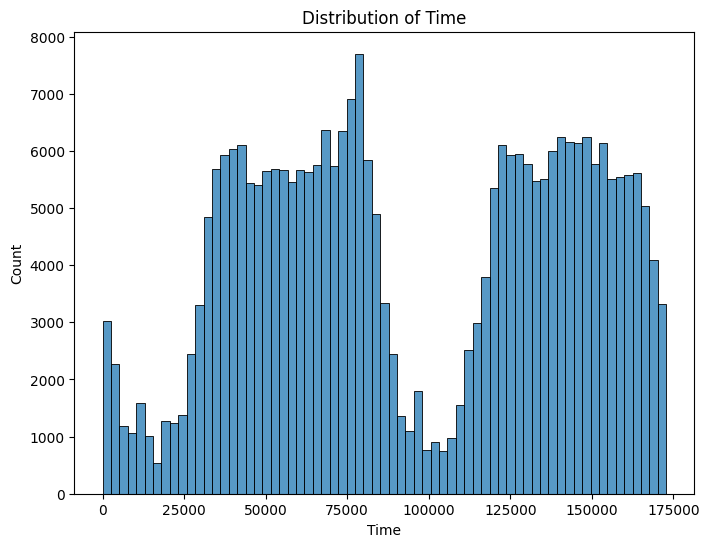

In [19]:
plt.figure(figsize=(8,6))
plt.title('Distribution of Time')
sns.histplot(df.Time)

#### **Visualize fraudulent Vs normal transactions**

In [20]:
#fraud vs. normal transactions
counts = df.Class.value_counts()
normal = counts[0]
fraudulent = counts[1]
perc_normal = (normal/(normal+fraudulent))*100
perc_fraudulent = (fraudulent/(normal+fraudulent))*100
print('There were {} non-fraudulent transactions ({:.3f}%) and {} fraudulent transactions ({:.3f}%).'.format(normal, perc_normal, fraudulent, perc_fraudulent))

There were 284315 non-fraudulent transactions (99.827%) and 492 fraudulent transactions (0.173%).


Text(0.5, 0, 'Class (0:Non-Fraudulent, 1:Fraudulent)')

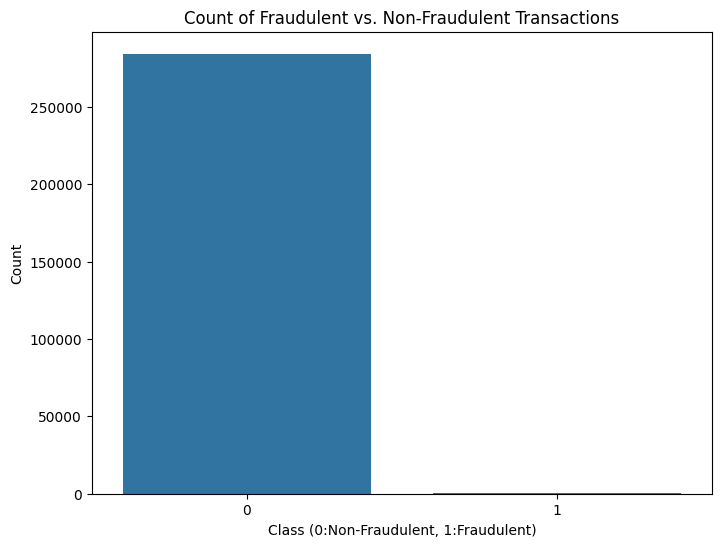

In [21]:
plt.figure(figsize=(8,6))
sns.barplot(x=counts.index, y=counts)
plt.title('Count of Fraudulent vs. Non-Fraudulent Transactions')
plt.ylabel('Count')
plt.xlabel('Class (0:Non-Fraudulent, 1:Fraudulent)')

#### **Features Correlation**

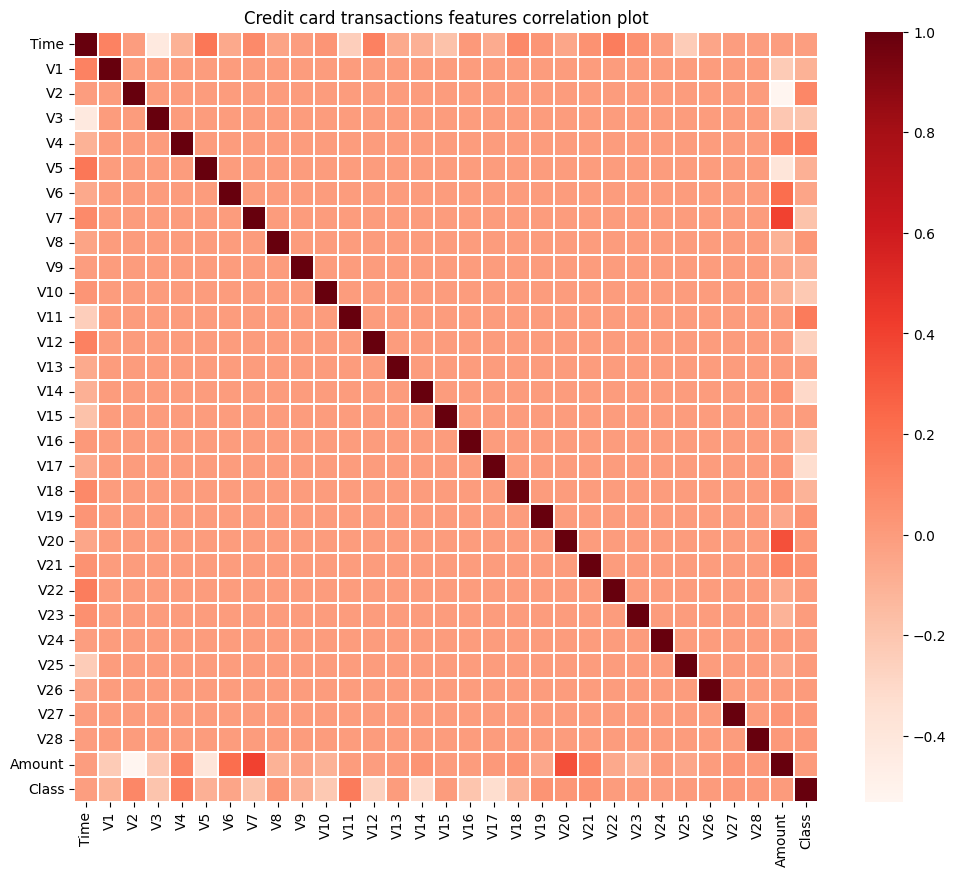

In [22]:
plt.figure(figsize = (12,10))
plt.title('Credit card transactions features correlation plot')
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

- As expected, there is no notable correlation between features **V1-V28**.
- There are certain correlations between some of these features and **Time** (inverse correlation with **V3**) and **Amount** (direct correlation with **V7** and **V20**, inverse correlation with **V1** and **V5**).

- Let's plot the correlated and inverse correlated values on the same graph.

- Let's start with the direct correlated values: {**V20;Amount**} and {**V7;Amount**}.

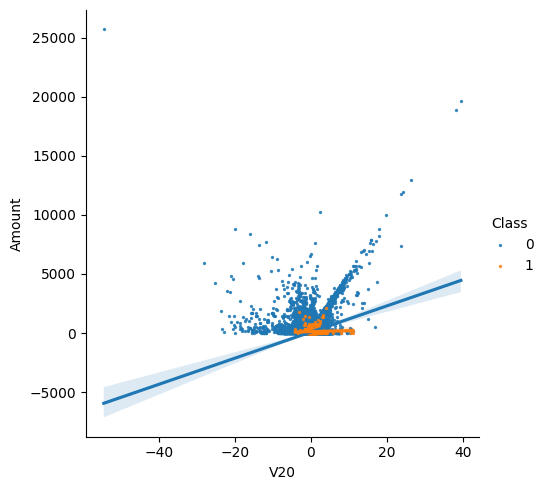

In [23]:
s = sns.lmplot(x = 'V20', y = 'Amount',data = df, hue = 'Class', fit_reg = True, scatter_kws = {'s':2})
plt.show()

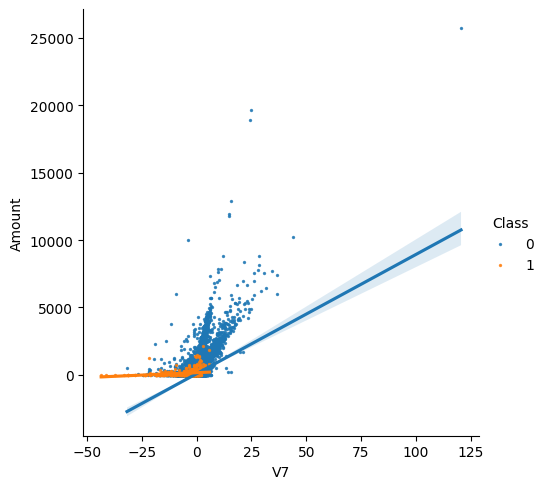

In [24]:
s = sns.lmplot(x = 'V7', y = 'Amount',data = df, hue = 'Class', fit_reg = True, scatter_kws = {'s':2})
plt.show()

We can confirm that the two couples of features are correlated (the regression lines for **Class = 0** have a positive slope, whilst the regression line for **Class = 1** have a smaller positive slope).

Let's now plot now the inverse correlated values.

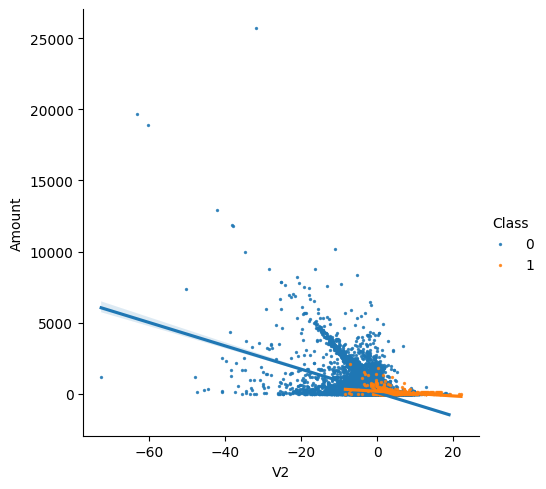

In [25]:
s = sns.lmplot(x = 'V2', y = 'Amount', data = df, hue = 'Class', fit_reg = True, scatter_kws = {'s':2})
plt.show()

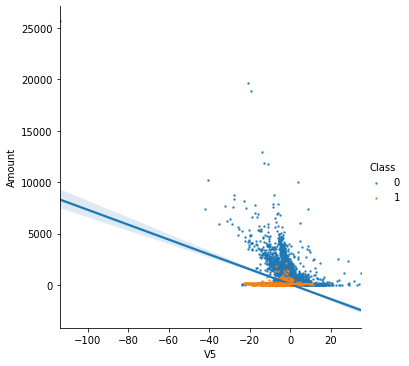

In [ ]:
s = sns.lmplot(x = 'V5', y = 'Amount', data = df, hue = 'Class', fit_reg = True, scatter_kws = {'s':2})
plt.show()

- We can confirm that the two couples of features are inverse correlated (the regression lines for **Class = 0** have a negative slope while the regression lines for **Class = 1** have a very small negative slope).

#### **Features density plot**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.



<Figure size 432x288 with 0 Axes>

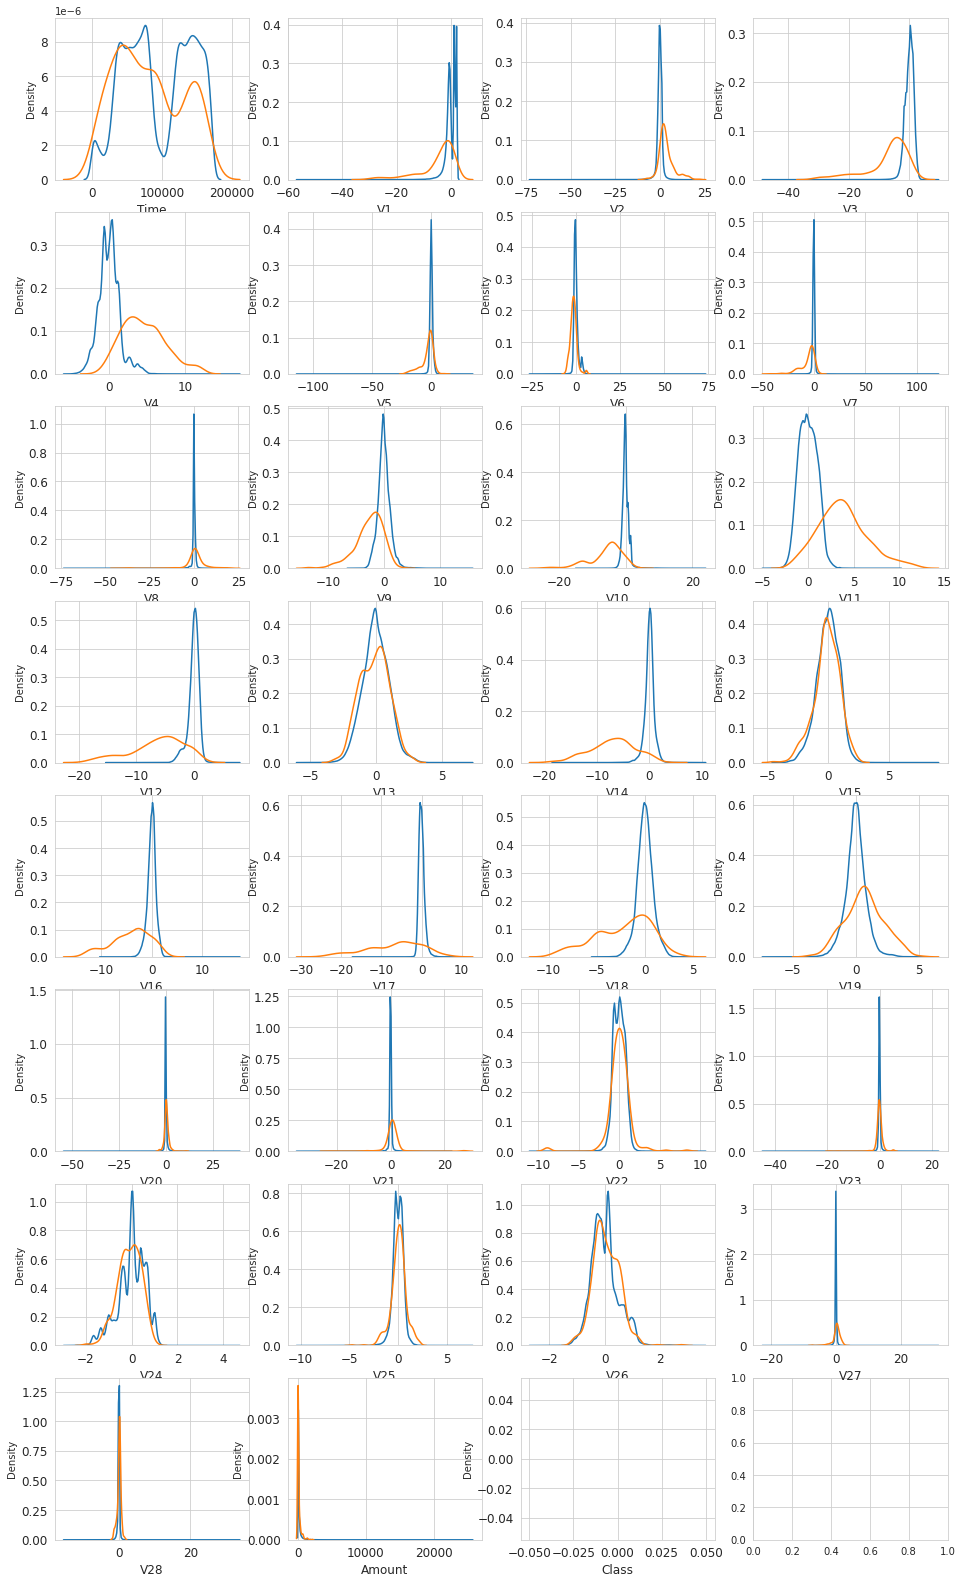

In [ ]:
var = df.columns.values

i = 0
t0 = df.loc[df['Class'] == 0]
t1 = df.loc[df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], label = "Class = 0")
    sns.kdeplot(t1[feature], label = "Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.show()


- For some of the features we can observe a good selectivity in terms of distribution for the two values of **Class: V4, V11** have clearly separated distributions for **Class** values 0 and 1, **V12**, **V14**, **V18** are partially separated, **V1**, **V2**, **V3**, **V10** have a quite distinct profile, whilst **V25**, **V26**, **V28** have similar profiles for the two values of Class.

- In general, with just few exceptions (**Time** and **Amount**), the features distribution for legitimate transactions (values of **Class = 0**) is centered around 0, sometime with a long queue at one of the extremities. In the same time, the fraudulent transactions (values of **Class = 1**) have a skewed (asymmetric) distribution.

## **5. Predictive Modelling**

- Now, we will move on to predictive modelling. We will define predictor and target values and evaluate various model performance on them. So, let's do it.

#### **Define predictors and target values**

- Now, let's define the predictor features and target values.

In [ ]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

#### **Split data in train, test and validation set**

- Now, let's define train, validation and test sets.

- First, we will split the dataset into train and test set as follows-

In [ ]:
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )


- Now, we will split the training set into train and validation set.

In [ ]:
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

### **Random Forest Classifier**

- Now, we will first start with the Random Forest Classifier  model.

- Define model parameters - Let's set the parameters for the model. Let's run a model using the training set for training. Then, we will use the validation set for validation.

- We will use as validation criterion **GINI**. Its formula is **GINI = 2 * (AUC) - 1**, where **AUC** is the **Receiver Operating Characteristic - Area Under Curve (ROC-AUC)**. Number of estimators is set to **100** and number of parallel jobs is set to **4**.

- We start by initializing the **RandomForestClassifier**.

In [ ]:
clf = RandomForestClassifier(n_jobs=NO_JOBS,
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

- Now, let's train the Random Forest Classifier.

In [ ]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=2018, verbose=False,
                       warm_start=False)

- Now, let's predict the target values for the valid_df data, using predict function.

In [ ]:
preds = clf.predict(valid_df[predictors])

#### **Features importance**

- Now, let's visualize the features importance.

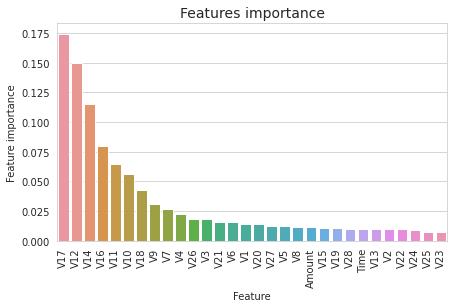

In [ ]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

- The most important features are **V17**, **V12**, **V14**, **V16**, **V11**, **V10**.

#### **Confusion matrix**

- Now, let's plot the confusion matrix for the results we obtained.

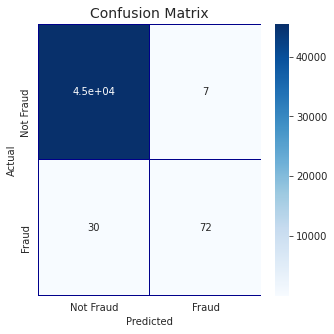

In [ ]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

 #### **Type I error** and **Type II error**

- Now, confussion matrix is not a very good tool to represent the results in the case of highly unbalanced data, like in this case. We will actually need a different metric that accounts in the same time for the selectivity and specificity of the method we are using, so that we minimize in the same time both Type I errors and Type II errors.

- **Null Hypothesis (H0)** - The transaction is not a fraud.
- **Alternative Hypothesis (H1)** - The transaction is a fraud.

- **Type I error** - We reject the null hypothesis when the null hypothesis is actually true.
- **Type II error** - We fail to reject the null hypothesis when the the alternative hypothesis is true.

- **Cost of Type I error** - We erroneously presume that the the transaction is a fraud, and a true transaction is rejected.
- **Cost of Type II error** - We erroneously presume that the transaction is not a fraud and a ffraudulent transaction is accepted.


- So, **Type II error** is more dangerous than a **Type I error**.

#### **ROC-AUC Score**

- Now, let's calculate the ROC-AUC Score of the Random Forest Classifier model.

In [ ]:
roc_auc_score(valid_df[target].values, preds)

0.8528641975628091

- So, the **ROC-AUC score** obtained with Random Forrest Classifier is 0.85.

### **AdaBoost Classifier**

- **AdaBoost Classifier** stands for Adaptive Boosting Classifier

#### **Initialize the model**

- Let's set the parameters for the model and initialize the model.



In [ ]:
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)


#### **Fit the model**

- Now, let's fit the model.

In [ ]:
clf.fit(train_df[predictors], train_df[target].values)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.8,
                   n_estimators=100, random_state=2018)

#### **Predict the target values**

- Let's now predict the target values for the valid_df data, using predict function.

In [ ]:
preds = clf.predict(valid_df[predictors])

#### **Features importance**

- Let's see the features importance.

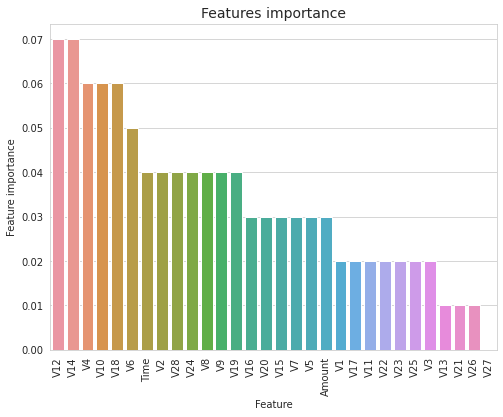

In [ ]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (8,6))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

#### **Confusion matrix**

- Let's visualize the confusion matrix.

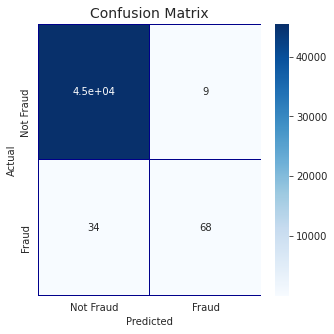

In [ ]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

#### **ROC-AUC Score**

Let's calculate also the ROC-AUC.

In [ ]:
roc_auc_score(valid_df[target].values, preds)

0.8332343604519027

The ROC-AUC score obtained with AdaBoostClassifier is 0.83.

### **CatBoost Classifier**

- **CatBoost Classifier** is a gradient boosting for decision trees algorithm with support for handling categorical data.

#### **Initialize the model**

- Let's set the parameters for the model and initialize the model.

In [ ]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [ ]:
clf.fit(train_df[predictors], train_df[target].values,verbose=True)


0:	total: 574ms	remaining: 4m 46s
50:	total: 24.7s	remaining: 3m 37s
100:	total: 48s	remaining: 3m 9s
150:	total: 1m 10s	remaining: 2m 43s
200:	total: 1m 33s	remaining: 2m 19s
250:	total: 1m 56s	remaining: 1m 55s
300:	total: 2m 19s	remaining: 1m 32s
350:	total: 2m 42s	remaining: 1m 9s
400:	total: 3m 5s	remaining: 45.8s
450:	total: 3m 28s	remaining: 22.6s
499:	total: 3m 50s	remaining: 0us


#### **Predict the target values**

- Let's now predict the target values for the **val_df** data, using predict function.

In [ ]:
preds = clf.predict(valid_df[predictors])

#### **Features importance**

- Let's see also the features importance.

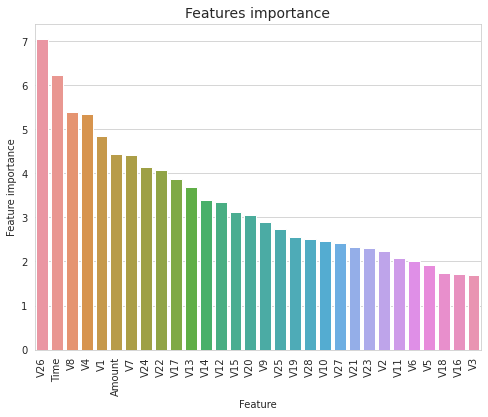

In [ ]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (8,6))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

#### **Confusion matrix**

- Let's visualize the confusion matrix.

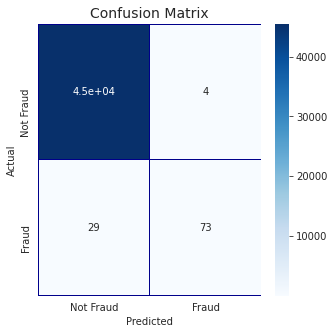

In [ ]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

#### **ROC-AUC Score**

- Now, let's calculate also the ROC-AUC Score.


In [ ]:
roc_auc_score(valid_df[target].values, preds)

0.8577991493075996

- The ROC-AUC score obtained with CatBoostClassifier is 0.86.



### **XGBoost Classifier**


- **XGBoost** is a gradient boosting algorithm.

- Let's initialize the model.

- We initialize the DMatrix objects for training and validation, starting from the datasets. We also set some of the parameters used for the model tuning.

In [ ]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)


In [ ]:
#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]


In [ ]:
# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE


#### **Train the model**

- Now, let's train the model.

In [ ]:
model = xgb.train(params,
                dtrain,
                MAX_ROUNDS,
                watchlist,
                early_stopping_rounds=EARLY_STOP,
                maximize=True,
                verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.889519	valid-auc:0.852739
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.939441	valid-auc:0.881959
[100]	train-auc:0.944161	valid-auc:0.890967
[150]	train-auc:0.977186	valid-auc:0.964228
[200]	train-auc:0.990128	valid-auc:0.982695
[250]	train-auc:0.994442	valid-auc:0.986025
[300]	train-auc:0.996408	valid-auc:0.984589
Stopping. Best iteration:
[258]	train-auc:0.995034	valid-auc:0.986645



- The best validation score (ROC-AUC) was 0.986, for round 258.

#### **Plot variable importance**

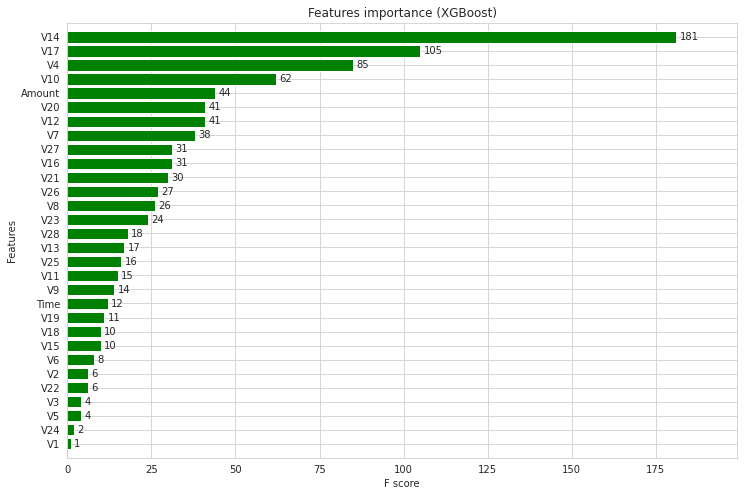

In [ ]:
fig, (ax) = plt.subplots(ncols=1, figsize=(12,8))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green")
plt.show()

#### **Predict test set**

- We used the train and validation sets for training and validation. We will use the trained model now to predict the target value for the test set.

In [ ]:
preds = model.predict(dtest)

#### **ROC-AUC Score**

- Now, let's calculate the ROC-AUC Score.

In [ ]:
roc_auc_score(test_df[target].values, preds)

0.9770317611058352

- The ROC- AUC score for the prediction of fresh data (test set) is 0.977.

### **LightGBM Classifier**

- Now, we will  predict with another gradient boosting algorithm - LightGBM Classifier model.

#### **Define model parameters**

- Now, let's set the parameters for the model. We will use these parameters for the lgb model.

In [ ]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced
         }

#### **Initialize the model**

- Now, let's initialize the model, creating the Datasets data structures from the train and validation sets.

In [ ]:
dtrain = lgb.Dataset(train_df[predictors].values,
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

#### **Run the model**

- Now, let's run the model, using the **train** function.

In [ ]:
evals_results = {}

model = lgb.train(params,
                  dtrain,
                  valid_sets=[dtrain, dvalid],
                  valid_names=['train','valid'],
                  evals_result=evals_results,
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=2*EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL,
                  feval=None)

Training until validation scores don't improve for 100 rounds.
[50]	train's auc: 0.97289	valid's auc: 0.967126
[100]	train's auc: 0.987513	valid's auc: 0.972525
[150]	train's auc: 0.988872	valid's auc: 0.93531
Early stopping, best iteration is:
[85]	train's auc: 0.987093	valid's auc: 0.974528


- We can see that the best validation score was obtained for round 85, for which AUC ~= 0.974.

#### **Plot variable importance**

- Now, let's plot variable importance

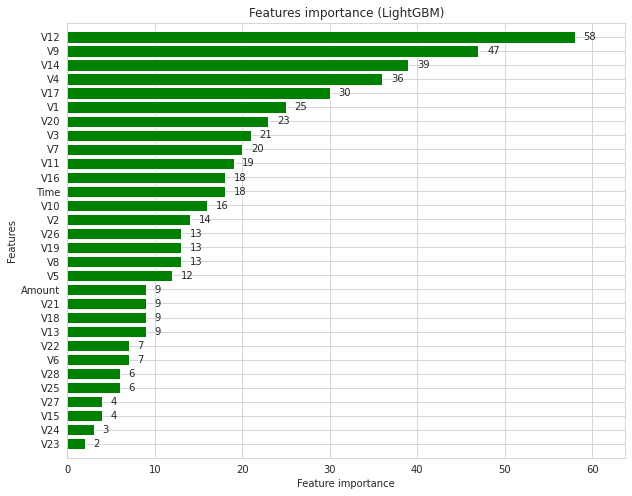

In [ ]:
fig, (ax) = plt.subplots(ncols=1, figsize=(10,8))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax, color="green")
plt.show()

#### **Predict test data**


- Now, let's predict the target for the test data.

In [ ]:
preds = model.predict(test_df[predictors])


#### **ROC-AUC Score**

- Now, let's calculate the ROC-AUC score for the prediction.

In [ ]:
roc_auc_score(test_df[target].values, preds)

0.9459470296507333

- The ROC-AUC score obtained for the test set is 0.946.

#### **Training and validation using cross-validation**

- We will now use now cross-validation. We will use cross-validation (KFolds) with 5 folds. Data is divided in 5 folds and, by rotation, we are training using 4 folds (n-1) and validate using the 5th (nth) fold.

- Test set is calculated as an average of the predictions.

In [ ]:
kf = KFold(n_splits = NUMBER_KFOLDS, random_state = RANDOM_STATE, shuffle = True)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
n_fold = 0
for train_idx, valid_idx in kf.split(train_df):
    train_x, train_y = train_df[predictors].iloc[train_idx],train_df[target].iloc[train_idx]
    valid_x, valid_y = train_df[predictors].iloc[valid_idx],train_df[target].iloc[valid_idx]

    evals_results = {}
    model =  LGBMClassifier(
                  nthread=-1,
                  n_estimators=2000,
                  learning_rate=0.01,
                  num_leaves=80,
                  colsample_bytree=0.98,
                  subsample=0.78,
                  reg_alpha=0.04,
                  reg_lambda=0.073,
                  subsample_for_bin=50,
                  boosting_type='gbdt',
                  is_unbalance=False,
                  min_split_gain=0.025,
                  min_child_weight=40,
                  min_child_samples=510,
                  objective='binary',
                  metric='auc',
                  silent=-1,
                  verbose=-1,
                  feval=None)
    model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric= 'auc', verbose= VERBOSE_EVAL, early_stopping_rounds= EARLY_STOP)

    oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
    test_preds += model.predict_proba(test_df[predictors], num_iteration=model.best_iteration_)[:, 1] / kf.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = predictors
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1

    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, train_x, train_y, valid_x, valid_y
    gc.collect()
    n_fold = n_fold + 1
train_auc_score = roc_auc_score(train_df[target], oof_preds)
print('Full AUC score %.6f' % train_auc_score)

Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.962157	valid_1's auc: 0.989338
Early stopping, best iteration is:
[13]	training's auc: 0.968109	valid_1's auc: 0.99314
Fold  1 AUC : 0.993140
Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.981643	valid_1's auc: 0.95593
Early stopping, best iteration is:
[10]	training's auc: 0.979098	valid_1's auc: 0.965326
Fold  2 AUC : 0.965326
Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.979434	valid_1's auc: 0.943348
Early stopping, best iteration is:
[35]	training's auc: 0.982207	valid_1's auc: 0.942698
Fold  3 AUC : 0.942698
Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.972729	valid_1's auc: 0.989338
[100]	training's auc: 0.97498	valid_1's auc: 0.994546
[150]	training's auc: 0.976713	valid_1's auc: 0.994725
Early stopping, best iteration is:
[118]	training's auc: 0.974884	valid_1's auc: 0.995364
Fol

- The AUC score for the prediction from the test data was 0.931823.

- We prepare the test prediction, from the averaged predictions for test over the 5 folds.

## **6. Results and conclusion**


- We investigated the data, checking for data unbalancing, visualizing the features and understanding the relationship between different features. We then investigated two predictive models. The data was split in 3 parts, a train set, a validation set and a test set. For the first three models, we only used the train and test set.

- We started with RandomForrestClassifier, for which we obtained an AUC score of 0.85 when predicting the target for the test set.

- We followed with an AdaBoostClassifier model, with lower AUC score (0.83) for prediction of the test set target values.

- We then followed with an CatBoostClassifier, with the AUC score after training 500 iterations 0.86.

- We then experimented with a XGBoost model. In this case, se used the validation set for validation of the training model. The best validation score obtained was 0.986. Then we used the model with the best training step, to predict target value from the test data; the AUC score obtained was 0.977.

- We then presented the data to a LightGBM model. We used both train-validation split and cross-validation to evaluate the model effectiveness to predict 'Class' value, i.e. detecting if a transaction was fraudulent. With the first method we obtained values of AUC for the validation set around 0.974. For the test set, the score obtained was 0.946.
With the cross-validation, we obtained an AUC score for the test prediction of 0.93.






## **7. References**


The concepts and ideas in this project are taken from the following websites -

1. [Credit-Card Fraud Detection Dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud)
2. [Random Forest Classifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
3. [AdaBoost Classifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)
4. [CatBoost Classifier Documentation](https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html)
5. [XGBoost Python API Reference](https://xgboost.readthedocs.io/en/latest/python/python_api.html)
6. [LightGBM Python Implemwentation](https://github.com/Microsoft/LightGBM/tree/master/python-package)